In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from glob import glob
from multiprocessing import cpu_count
from multiprocessing import Pool

# custom functions for multiprocessing
from read_csv import read_csv
from get_DBSCAN_mask import get_DBSCAN_mask

In [2]:
def get_span(df0):
    """
    Get span for cropping scan based on highest point (Z-data)
    within profile in the middle of scan. 
    Get y-value of zMax at the profile in the middle of the scan. 
    Use yMean to adjust y-values. Put zMax at y=0.
    Only works if there is one wall visible in the scan.
    
    Parameters
    ----------
    df0 : DataFrame
    data of first layer
    
    Returns
    -------
    span : range
        range of integers within the borders
    yMean: float
        y at zMax
    """

    # load data
    r = len(df0.index) # rows
    dfy, _, dfz = df0[:int(1/3*r)],df0[int(1/3*r):int(2/3*r)],df0[int(2/3*r):]
    dfz = dfz.reset_index(drop=True)

    # one row of z data from middle of scan in xDir
    dfy_row = dfy.iloc[int(1/2*len(dfy.index)),:]
    dfz_row = dfz.iloc[int(1/2*len(dfz.index)),:]

    # remove empty strings ''
    dfy_row = dfy_row.replace('', np.nan, regex=True).dropna()
    dfz_row = dfz_row.replace('', np.nan, regex=True).dropna()

    # restrict search for max(z) to middle of scan in yDir
    dfz_row = dfz_row[240:1041] # middle = 640

    # get index of max(z)
    max_id = dfz_row.astype('float').idxmax(axis=0)

    ########################################################
    # get span arround highest point
    width = 200
    b0 = max_id - width # lower border index
    b1 = max_id + width # upper border index
    span = range(b0,b1)

    # get yMean at max(z)
    yMean = float(dfy_row[max_id])

    return span, yMean

In [3]:
def df2float(df_in,n):
    """
    Replace empty strings with NaN and convert strings to float

    Parameters
    ----------
    df_in : DataFrame
        data from read_csv
    n : int
        drop rows with more than n NaN values

    Returns
    -------
    df : DataFrame
        dataFrame with NaN and values dtype = 'float'
    """

    # drop rows with more than n NaN values
    df = df_in.dropna(thresh=df_in.shape[1]-n)
    
    try:
        df = df.replace('', np.nan, regex=True) # replace empty string with NaN
    except:
        print('no NaN detected')
    finally:
        df = df.astype('float')
        df = df.reset_index()
    return df

In [4]:
def rot_y(df_in, angle_max):
    """
    Make baseplate parallel to x-axis.
    x-values are not adjusted after rotation to make slices with unique x-values remain.
    delta_x and delta_z form the a and b sides of a triangle with a 90° in between a and b.
    Due to the banana-shaped baseplate the angle is calculated from the middle.
    Therefore two angles are calculated. 
    Single outlier points (especially at the start/end of the data) may affect the 
    calculation of the correct angle. 
    Therefore the angle is calculated for EVERY POINT. The final angle is the median of all
    calculated angles which improves the stability of the algorithm without affecting 
    total computation time.
    
    Parameters
    ----------
    df : DataFrame
        data after df2float
    angle_max: float
        angle in degrees, must be positive number
        straightening is applied when alpha > max. angle
        
    Returns
    -------
    df : DataFrame
        dataFrame with adjusted z-values
    """
    
    # load data
    df = df_in.copy()
    r = len(df.index) # rows
    dfx, dfz = df[int(1/3*r):int(2/3*r)],df[int(2/3*r):]
    dfx = dfx.reset_index(drop=True)
    dfz = dfz.reset_index(drop=True)

    # get average angle of base plate
    m = int(len(dfx.index)/2) # middle of rows
    a1 = dfx.iloc[m, 1] - dfx.iloc[:m, 1] # delta_x: middle to start  
    b1 = dfz.iloc[m, 1] - dfz.iloc[:m, 1] # delta_z
    a2 = dfx.iloc[-1:m:-1, 1] - dfx.iloc[m, 1] # delta_x: end to middle
    b2 = dfz.iloc[-1:m:-1, 1] - dfz.iloc[m, 1] # delta_z
    c1 = np.sqrt(np.square(a1) + np.square(b1)) # hypotenuse of triangle
    c2 = np.sqrt(np.square(a2) + np.square(b2))
    angle_rad1 = np.arcsin(b1/c1)
    angle_rad2 = np.arcsin(b2/c2)
    average_angle_rad = np.median(np.concatenate((angle_rad1,angle_rad2),axis=0))
   
    # rotate points arround y-axis
    if np.abs(np.rad2deg(average_angle_rad)) > angle_max:
        c,s = np.cos(average_angle_rad),np.sin(average_angle_rad)
        dfz = dfz.iloc[:,:]*c - dfx.iloc[:,:]*s # Apply the rotation to z coordinate only
        df[int(2/3*len(df.index)):] = dfz 
        print('baseplate angle = ' + str(np.round(np.rad2deg(average_angle_rad),3)) + '°')

    return df

In [5]:
def rot_x(df_in, angle_max):
    """
    Make baseplate parallel to y-axis.
    Rotate arround x-axis. 
    Made for V12 layer 02
    
    Parameters
    ----------
    df : DataFrame
        data after df2float
    angle_max: float
        angle in degrees, must be positive number
        straightening is applied when alpha > max. angle
        
    Returns
    -------
    df : DataFrame
        dataFrame with adjusted z-values
    """
    
    # load data
    df = df_in.copy()
    r = len(df.index) # rows
    dfy, dfx, dfz = df[:int(1/3*r)],df[int(1/3*r):int(2/3*r)],df[int(2/3*r):]
    dfx = dfx.reset_index(drop=True)
    dfz = dfz.reset_index(drop=True)

    # get average angle of base plate
    # y,z-data of one slice is in one row!
    a = dfy.iloc[0, 1] - dfy.iloc[0, -1] # dfy = [id=3074,12,11,... -11,-12]
    b = dfz.iloc[0, 1] - dfz.iloc[0, -1] # dfz = [id=3074,0.3,1.4,...,11.2,12.5]
    c = np.sqrt(np.square(a) + np.square(b)) # hypotenuse of triangle
    average_angle_rad = np.arcsin(b/c)
    
    # rotate points arround y-axis
    if np.abs(np.rad2deg(average_angle_rad)) > angle_max:
        c,s = np.cos(average_angle_rad),np.sin(average_angle_rad)
        dfz = dfz.iloc[:,:]*c - dfy.iloc[:,:]*s # Apply the rotation to z coordinate only
        df[int(2/3*len(df.index)):] = dfz
        print('baseplate angle = ' + str(np.round(np.rad2deg(average_angle_rad),3)) + '°')

    return df

In [6]:
def set_z(df):
    """
    Adjust z-values to make z(base plate) = 0.

    Parameters
    ----------
    df : DataFrame
        data after df2float

    Returns
    -------
    df : DataFrame
        dataFrame with corrected z-values
    """

    # load data
    r = len(df.index) # rows
    dfz = df[int(2/3*r):].copy()

    # remove low values which typically exist in flawed scans
    dfz[dfz < 0] = np.nan

    # Get the median of the first column
    median_first_col = dfz.iloc[:, 1].median()
    # Get the median of the last column
    median_last_col = dfz.iloc[:, -1].median()
    # get z of baseplate
    zBP = min(median_first_col,median_last_col)

    # set z at base plate to 0
    dfz.loc[:, dfz.columns[1:]] -= zBP
    df[int(2/3*len(df.index)):] = dfz 

    return df

In [7]:
def get_x0(df):
    """
    X coordinates of different scans do not overlap due to 
    manual starting/stopping of scans. 
    Every weld after the first weld contains at least the height 
    of the first weld.
    Notice: The data from start of scan is used because there is insufficient data 
    at the end of a wall due to laser scanning triangulation method. 
        
    Parameters
    ----------
    df: dataframe
        data of any layer after applying span & df2float
        shape must be (N,401)
    
    Returns
    -------
    x0: float
        x-coordinate at which the wall reaches a critical height z=1 mm
    """

    # load data
    r = len(df.index) # rows
    dfx, dfz = df[int(1/3*r):int(2/3*r)],df[int(2/3*r):]
    dfx = dfx.reset_index(drop=True)
    dfz = dfz.reset_index(drop=True)

    # get x and z data for middle col
    x = dfx.iloc[:,200].to_numpy()
    z = dfz.iloc[:,200].to_numpy()

    # adjust z-values to get rid of bending base plate
    z = z-z[0]

    # find x-coordinate of start-hump/end-hump in data
    indices = np.concatenate(np.where(z > 1)).reshape(-1)
    
    try:
        x0 = x[indices[0]] # start of wall
    except:
        x0 = x[0] - 20.3 # for V12 layer 09, value must be x-value from measurement
        print('Warning! No Start found! Change value MANUALLY if this error occurs!')

    # # plot
    # x1 = x[indices[-1]] # end of wall
    # z0 = z[indices[0]]
    # z1 = z[indices[-1]]
    # fig, ax = plt.subplots(figsize=(4.24,3))
    # ax.scatter(x,z,marker='.')
    # ax.scatter(x0,z0,marker='.',c='red') # start of wall
    # ax.scatter(x1,z1,marker='.',c='orange') # end of wall
    # plt.show()

    # print('y = '+ str(dfy.iloc[1,200]))
    # print('x0 = '+str(x0))
    # # plot scan at x0 - TESTING
    # fig, ax = plt.subplots(figsize=(4.24,3))
    # ax.scatter(dfy.iloc[indices[0],1:].to_numpy(),
    #            dfz.iloc[indices[0],1:].to_numpy(),
    #            marker='.')
    # plt.show()

    return x0

In [8]:
def in_max_height(df,hMax):
    """
    Replace z-values smaller than zMax - hMax with NaN.

    Parameters
    ----------
    df : DataFrame
        data after df2float
    hMax : float
        max. allowed height of layer

    Returns
    -------
    df : DataFrame
        dataFrame with NaN for z-values < zMax - hMax
    """

    # load z-data
    dfz = df[int(2/3*len(df.index)):].copy()

    # Find the maximum z-value in each row
    max_values = dfz.iloc[:,1:].max(axis=1)

    # Set z < max_values - hMax to NaN
    df[dfz < max_values.values[:, None] - hMax] = np.nan

    return df

In [9]:
def df2array(df):
    """
    Return the X,Y,Z as one array A with three columns.
    Delete NaN from arrays

    Parameters
    ----------
    df : DataFrame
        data from read_csv

    Returns
    -------
    A : ndarray
        1D-arrays containing data of laserscan
    """

    r = len(df.index) # rows
    dfy, dfx, dfz = df[:int(1/3*r)],df[int(1/3*r):int(2/3*r)],df[int(2/3*r):]
    dfx = dfx.reset_index(drop=True)
    dfz = dfz.reset_index(drop=True)
    
    # convert to 2D numpy array
    X2 = dfx.to_numpy()[:,1:] # [:,1:] to ignore index col
    Y2 = dfy.to_numpy()[:,1:]
    Z2 = dfz.to_numpy()[:,1:]

    # make 1D array
    X,Y,Z = X2.flatten(),Y2.flatten(),Z2.flatten()

    # delete all points with NaN values
    mask = ~np.isnan(Z)
    X,Y,Z = X[mask],Y[mask],Z[mask]

    # sort array for plot and np.gradient
    X,Y,Z = zip(*sorted(zip(X,Y,Z)))
    X,Y,Z = np.array(X),np.array(Y),np.array(Z)

    # Stack the arrays horizontally to create an array of shape(n,3) 
    A = np.column_stack((X, Y, Z))

    return A

In [10]:
def clustering(A,eps):
    """
    Apply DBSCAN to every slice of point cloud.
    Get the weld surface.

    Parameters
    ----------
    A : ndarray
        array of shape (N,3) 
        point cloud before clustering filter
    eps: float
        epsilon distance --> look in sklearn DBSCAN documentation

    Returns
    -------
    A_filtered : ndarray
        array of shape (N,3) 
        point cloud after clustering filter
    """

    # create an empty mask array
    mask = np.zeros((0),dtype=bool)

    # transform to dataFrame for groupby-function
    df = pd.DataFrame({'X':A[:,0],'Y':A[:,1],'Z':A[:,2]})

    # Group the data by unique values in the 'X' column
    grouped = df.groupby('X')

    # Apply DBSCAN to 'Y' and 'Z' columns for each unique 'X' value
    for x_value, group_df in grouped:
        # print(f"Group: {x_value}")
        
        # Extract 'Y' and 'Z' columns as input for DBSCAN
        features = group_df[['Y', 'Z']]

        # normalize data
        scaler = StandardScaler().fit(features)
        features = scaler.transform(features)
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=2,n_jobs=-1)
        labels = dbscan.fit_predict(features)

        # Replace -1 with 4 (sorting don't like -1)
        labels[labels == -1] = max(labels)+1

        # Add DBSCAN labels to the DataFrame
        group_df['labels'] = labels

        # Calculate average 'Z' value for each label
        label_avg_z = group_df.groupby('labels')['Z'].median()
        
        sorted_labels = label_avg_z.sort_values().index
        
        group_df['sorted_labels'] = group_df['labels'].map({label: i for i, label in 
                                                            enumerate(sorted_labels)})

        # Plot the results
        # if x_value > 76 and x_value < 77:
        if x_value == df.X[int(len(df.index)/2)]:
            plt.scatter(group_df['Y'], group_df['Z'], 
                        c=group_df['sorted_labels'], cmap='viridis')
            plt.xlabel('Y')
            plt.ylabel('Z')
            plt.title(f'Cluster Plot for x = {x_value} mm')
            plt.show()

        # append weld surface points to mask
        sorted_labels_list = group_df['sorted_labels'].tolist()
        new_mask = [val == max(sorted_labels_list) for val in sorted_labels_list]
        mask = np.concatenate([mask,new_mask])

    # get weld surface
    return A[mask],grouped

In [11]:
def clustering_multiprocess(A):
    """
    Apply DBSCAN to every slice of point cloud.
    Get the weld surface.

    Parameters
    ----------
    A : ndarray
        array of shape (N,3) 
        point cloud before clustering filter

    Returns
    -------
    A_filtered : ndarray
        array of shape (N,3) 
        point cloud after clustering filter
    """

    # transform to dataFrame for groupby-function
    df = pd.DataFrame({'X':A[:,0],'Y':A[:,1],'Z':A[:,2]})

    # Group the data by unique values in the 'X' column
    grouped = df.groupby('X')

    # process the dataFrames in 'grouped' in parallel
    with Pool(processes=cpu_count()) as pool:
        mask_list = pool.map(get_DBSCAN_mask,[group_df for _, group_df in grouped])

    # make mask for A from masks of slices
    mask = np.concatenate(mask_list)
    
    return A[mask]

# load data

In [12]:
if __name__ ==  '__main__':
    ########## IMPORT DATA ##########
    # MANUAL INPUT: set specimen Nr
    VNr = 1-1 # Example: VNr=0 --> V01

    # get time for performance monitoring 
    t0 = time.time()

    # Get a list of all files and folders within the data directory
    main_dir = r"C:\Users\mie\Documents\GIT_Repositories\scan_analyze"
    data_dir = main_dir + '\data'
    folders = [folder for folder in os.listdir(data_dir) 
            if os.path.isdir(os.path.join(data_dir, folder))] # only folders
  
    # get list of CSV files 
    spec_dir = data_dir + "\\" + folders[VNr]
    csv_files = glob(os.path.join(spec_dir, "*.csv")) 
    # csv_files = [csv_files[5]]
    
    # process the CSV files in parallel
    with Pool(processes=cpu_count()) as pool: 
        df_read = pool.map(read_csv, csv_files)
    print('read finished after: ' + str(np.round(time.time()-t0, 1)) + ' s')

    ########## PREPARE DATA ##########
    # get span for cropping dataFrames 
    span,yMean_at_zMax = get_span(df_read[0])

read finished after: 39.7 s


# processing loop

01/15


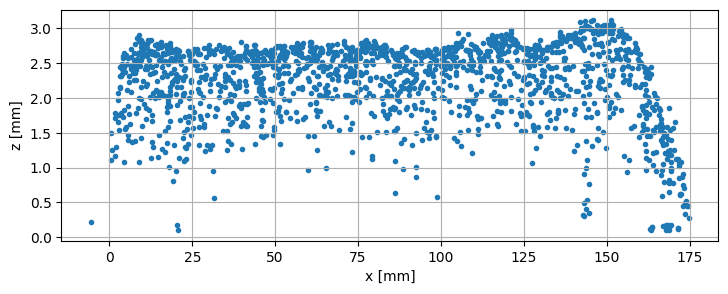

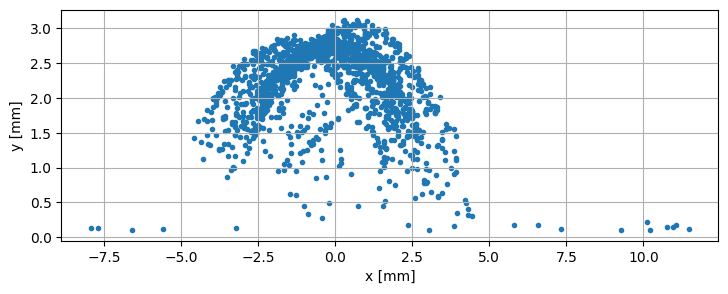

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_01.npy
02/15


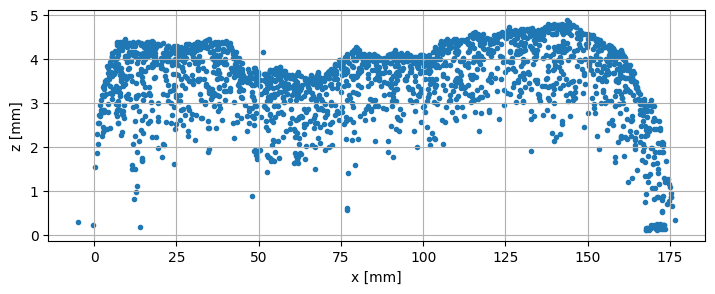

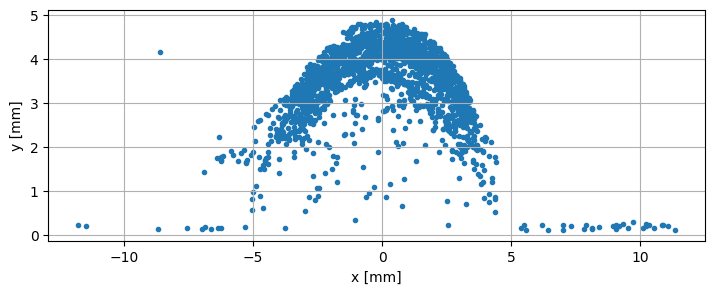

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_02.npy
03/15


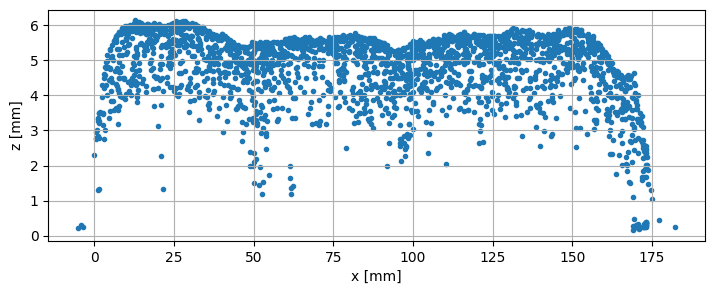

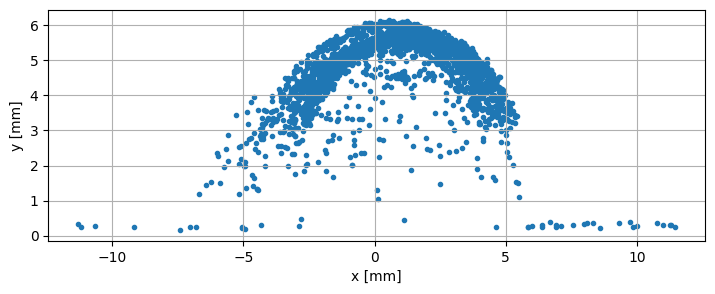

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_03.npy
04/15


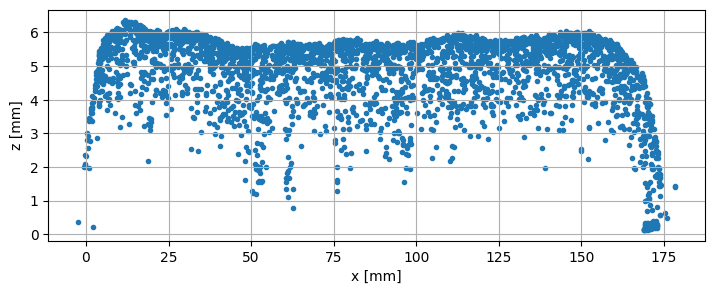

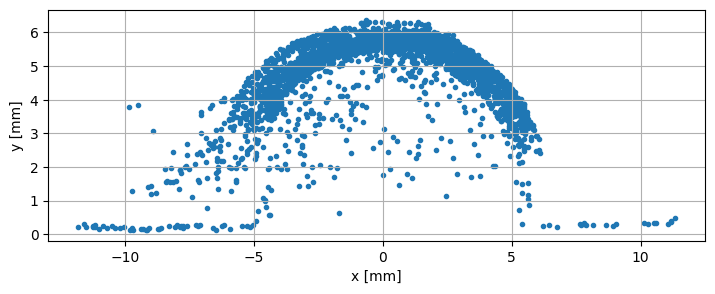

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_04.npy
05/15


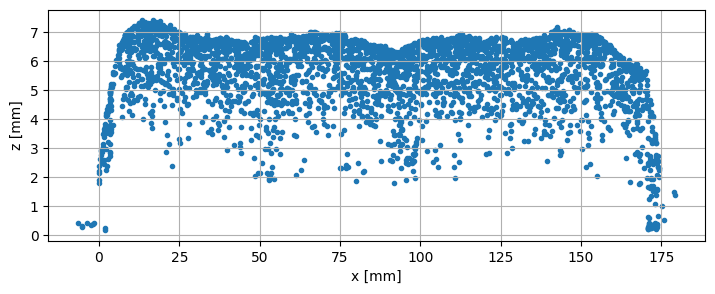

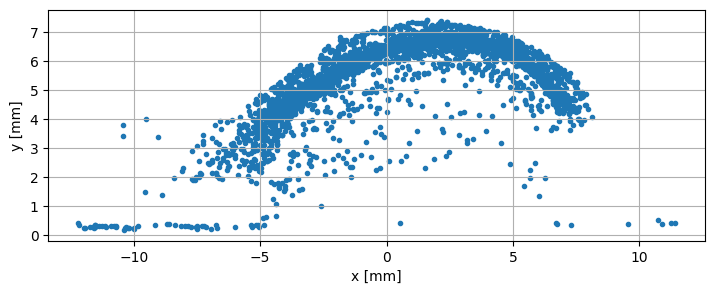

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_05.npy
06/15


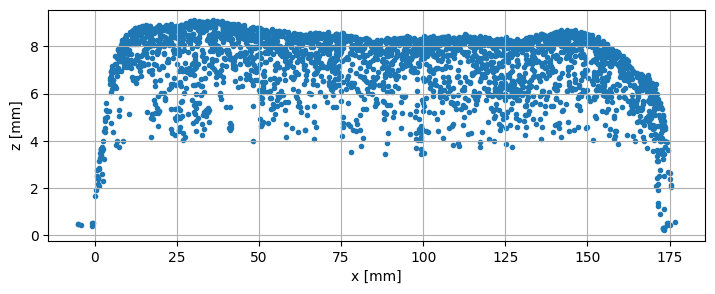

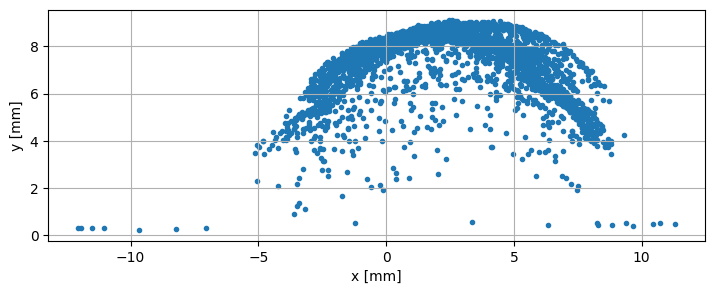

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_06.npy
07/15


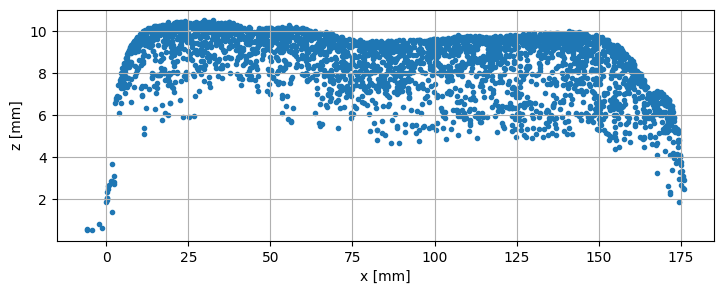

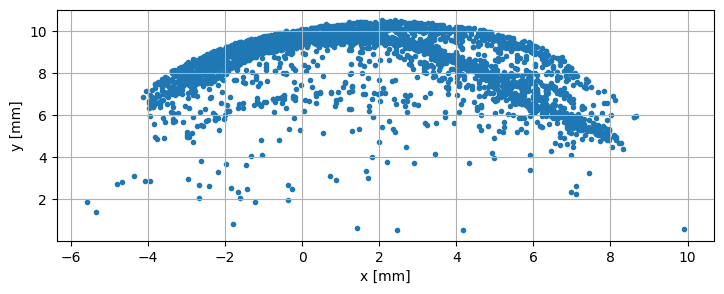

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_07.npy
08/15


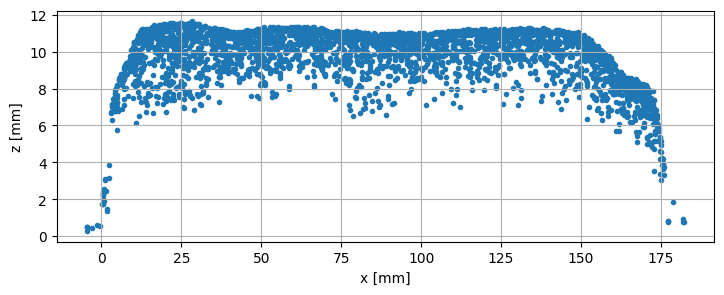

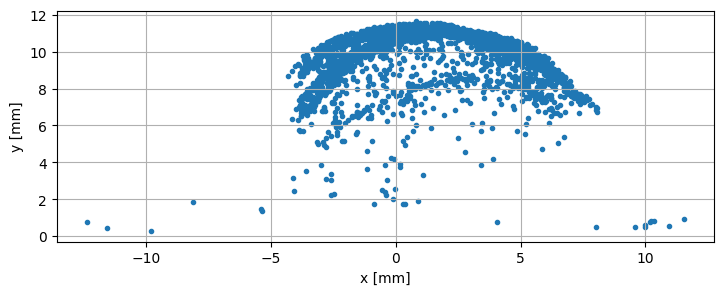

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_08.npy
09/15


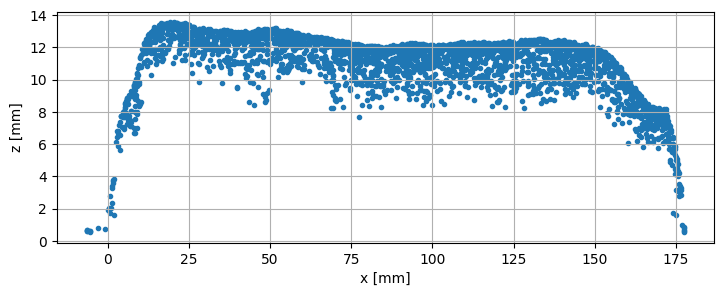

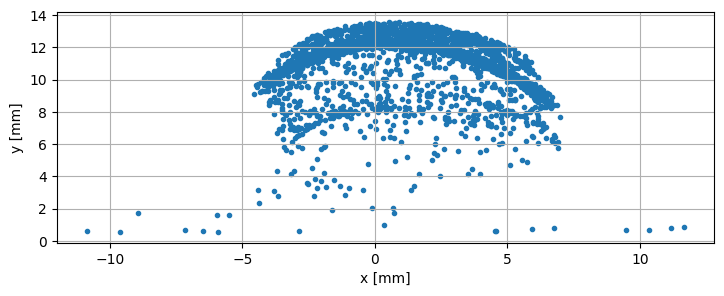

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_09.npy
10/15


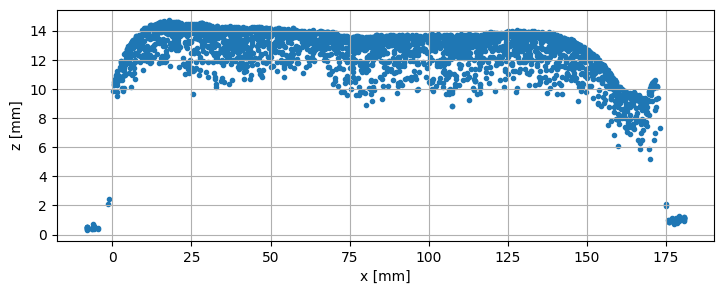

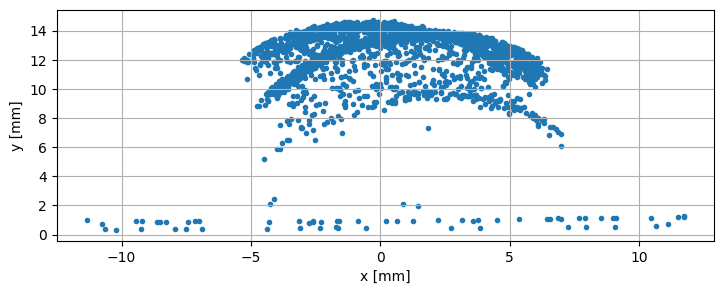

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_10.npy
11/15


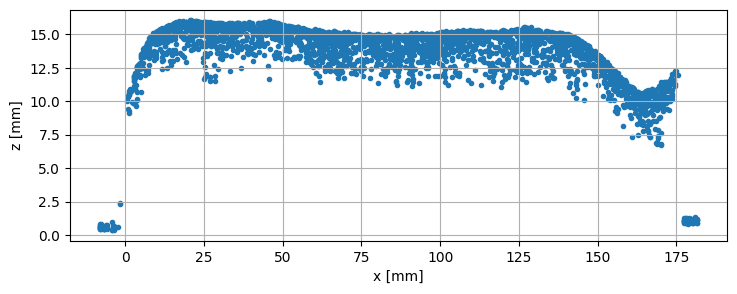

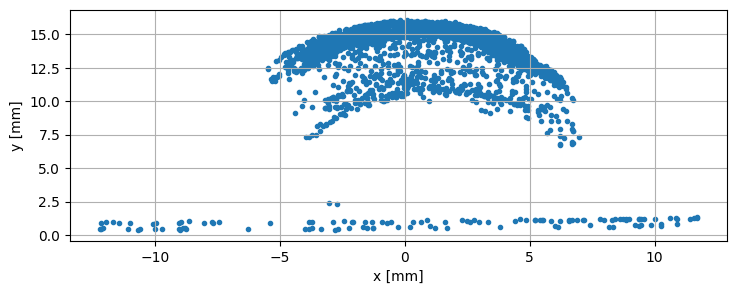

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_11.npy
12/15


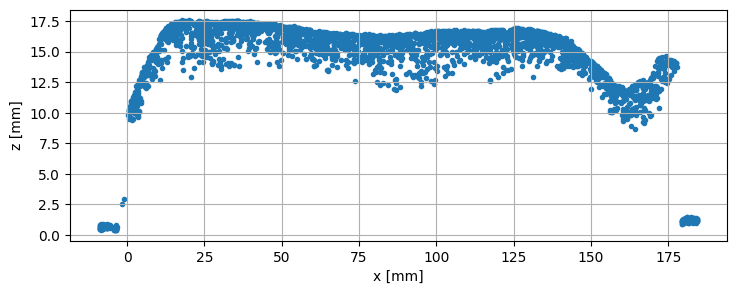

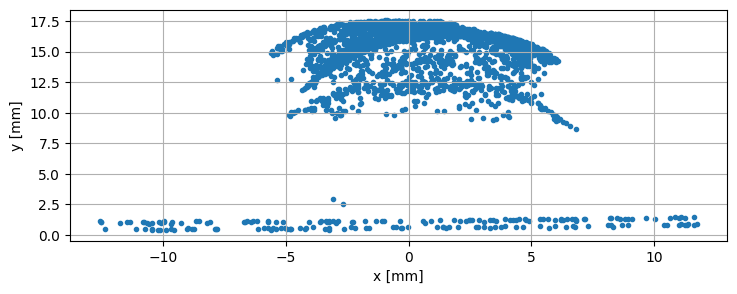

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_12.npy
13/15


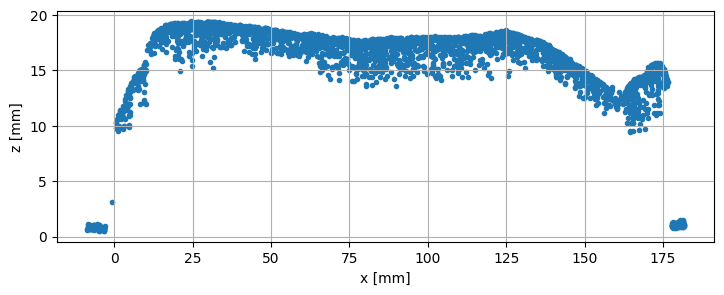

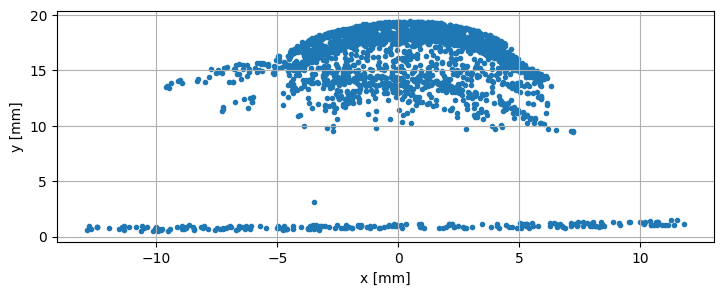

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_13.npy
14/15


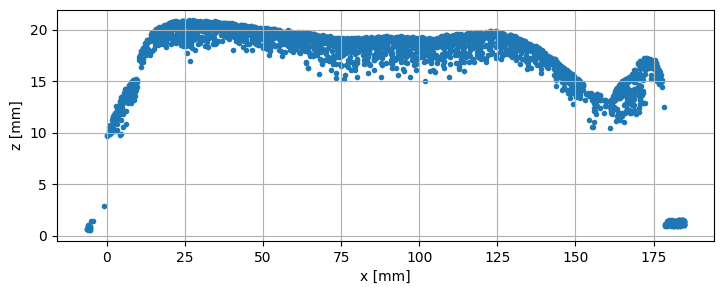

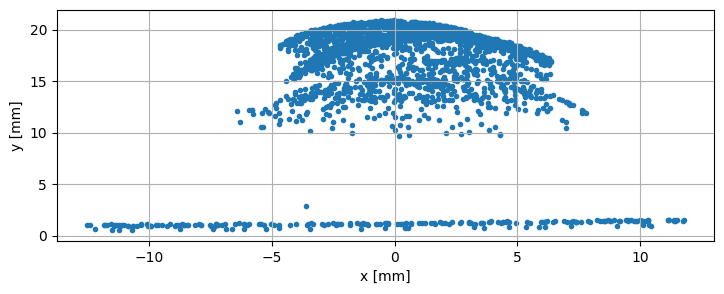

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_14.npy
15/15


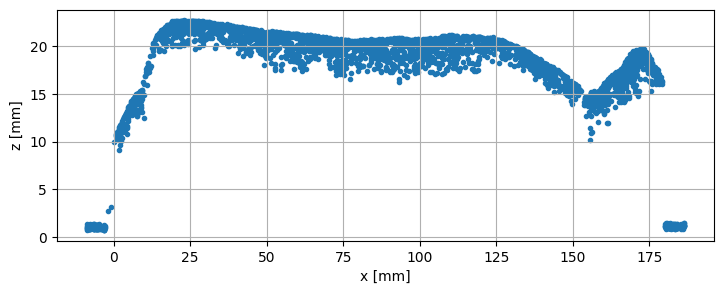

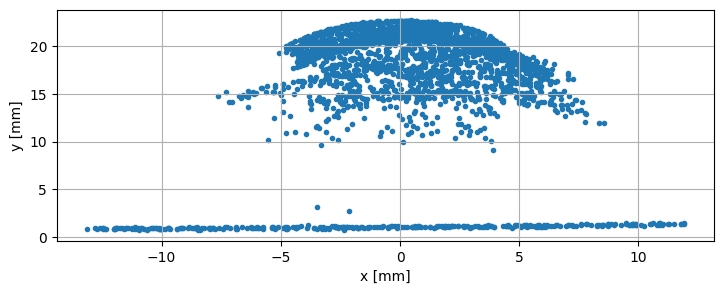

C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01\layer_15.npy


In [13]:
if __name__ == '__main__':
    for i, layer_file in enumerate(csv_files):
        # print progress
        print(layer_file[-6:-4] + '/' + str(len(csv_files)))

        # copy, crop, convert to float
        df = df_read[i].copy()
        df = df.iloc[:,span]
        df = df2float(df,5)

        # rotation, if baseplate crooked
        df = rot_y(df,angle_max=0.5) # adjust only z - rotate arround y-axis
        df = rot_x(df,angle_max=5) # adjust only z - rotate arround x-axis

        # adjust z - set baseplate to z=0
        df = set_z(df)

        # adjust x - scale x
        r = len(df.index) # rows
        v = [150,150,150,150,249,249,249,249,174,174,174,174,150,249,174,174,174] # mm/min
        df[int(1/3*r):int(2/3*r)] = df[int(1/3*r):int(2/3*r)].multiply(v[VNr]/(5*60)) # scan3D v=5 mm/s

        # adjust x - overlay two layers
        df[int(1/3*r):int(2/3*r)] = df[int(1/3*r):int(2/3*r)]-get_x0(df)

        # adjust y
        df[:int(1/3*len(df.index))] -= yMean_at_zMax

        # adjust z - delete points
        df = in_max_height(df,hMax=5)

        # make array from df
        A = df2array(df)

        # remove low points
        A = A[A[:,2]>0.1]

        ########## CLUSTER POINTS ##########
        # Cluster points and remove points outside of weld surface
        C = clustering_multiprocess(A)

        # plot processed data
        dfp=pd.DataFrame({'X':C[:,0],'Y':C[:,1],'Z':C[:,2]})
        dfp = dfp.sample(frac=0.01)
        fig, ax = plt.subplots(figsize=(2*4.24,3))
        ax.scatter(dfp.X,dfp.Z,marker='.')
        ax.set_xlabel('x [mm]')
        ax.set_ylabel('z [mm]')
        plt.grid(True)
        plt.show()

        # plot y-z-data
        fig, ax = plt.subplots(figsize=(2*4.24,3))
        ax.scatter(dfp.Y,dfp.Z,marker='.')
        ax.set_xlabel('x [mm]')
        ax.set_ylabel('y [mm]')
        plt.grid(True)
        plt.show()

        ########## SAVE POINTS TO A FILE ############
        npy_path_short = spec_dir + '\layer_0' + str(i+1) + '.npy'
        npy_path_long  = spec_dir + '\layer_' + str(i+1) + '.npy'
        file_path = npy_path_short if i+1 < 10 else npy_path_long       
        print(file_path)
        np.save(file_path, C)